In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import generate_objects, BunchTracker, track, compare_traces, compare_projections, Machine

from PyHEADTAIL_feedback.feedback import OneboxFeedback
from PyHEADTAIL_feedback.derived_processors import Bypass
from PyHEADTAIL_feedback.processors import CosineSumRegister, VectorSumRegister
from PyHEADTAIL_feedback.digital_processors import HilbertPhaseShiftRegister

np.random.seed(0)

PyHEADTAIL v1.9.4




In [2]:
#Generater bunch slicer and maps. See the code for generator in the file test_tools.py 

n_macroparticles = 1000
n_slices = 20
n_segments = 5
n_sigma_z = 3 

feedback_gain = 0.01
n_turns = 300

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(n_macroparticles,n_segments, n_slices,n_sigma_z)

machine = Machine() # machine parameters

In [3]:


slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

#random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]
    
bunch_init = copy.deepcopy(bunch_ref)
tracker_ref = BunchTracker(bunch_init)
maps_ref = [i for i in trans_map] + [long_map]
track(n_turns, bunch_init,maps_ref,tracker_ref)

In [4]:
# Register parameters
delay = 0
n_avg = 7

In [5]:
bunch_OneBox = copy.deepcopy(bunch_ref)
tracker_OneBox = BunchTracker(bunch_OneBox)
slicer_OneBox = copy.deepcopy(slicer_ref)

# signal processor chains
signal_processors_x = [Bypass()]
signal_processors_y = [Bypass()]

feedback_map = OneboxFeedback(feedback_gain,slicer_OneBox,signal_processors_x,signal_processors_y)
total_map_OneBox = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_OneBox,total_map_OneBox,tracker_OneBox)

In [6]:
bunch_cosine = copy.deepcopy(bunch_ref)
tracker_cosine = BunchTracker(bunch_cosine)
slicer_cosine = copy.deepcopy(slicer_ref)

# signal processor chains
processors_cosine_x = [CosineSumRegister(n_avg, machine.Q_x, delay)]
processors_cosine_y = [CosineSumRegister(n_avg, machine.Q_y, delay)]

feedback_map = OneboxFeedback(feedback_gain,slicer_cosine,processors_cosine_x,processors_cosine_y)
total_map_cosine = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_cosine,total_map_cosine,tracker_cosine)

In [7]:
bunch_vector = copy.deepcopy(bunch_ref)
tracker_vector = BunchTracker(bunch_vector)
slicer_vector = copy.deepcopy(slicer_ref)

# signal processor chains
processors_vector_x = [VectorSumRegister(n_avg, machine.Q_x, delay)]
processors_vector_y = [VectorSumRegister(n_avg, machine.Q_y, delay)]

feedback_map = OneboxFeedback(feedback_gain,slicer_vector,processors_vector_x,processors_vector_y)
total_map_vector = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_vector,total_map_vector,tracker_vector)

In [8]:
bunch_FIR = copy.deepcopy(bunch_ref)
tracker_FIR = BunchTracker(bunch_FIR)
slicer_FIR = copy.deepcopy(slicer_ref)

# signal processor chains
processors_FIR_x = [HilbertPhaseShiftRegister(n_avg, machine.Q_x, delay)]
processors_FIR_y = [HilbertPhaseShiftRegister(n_avg, machine.Q_y, delay)]

feedback_map = OneboxFeedback(feedback_gain,slicer_FIR,processors_FIR_x,processors_FIR_y)
total_map_FIR = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_FIR,total_map_FIR,tracker_FIR)

In [9]:
# bunch_add = copy.deepcopy(bunch_ref)
# tracker_add = BunchTracker(bunch_add)
# slicer_add = copy.deepcopy(slicer_ref)

# # signal processor chains
# processors_add_x = [BypassAddition()]
# processors_add_y = [BypassAddition()]

# feedback_map = OneboxFeedback(feedback_gain,slicer_add,processors_add_x,processors_add_y)
# total_map_add = [i for i in trans_map] + [long_map] + [feedback_map]

# track(n_turns, bunch_add,total_map_add,tracker_add)

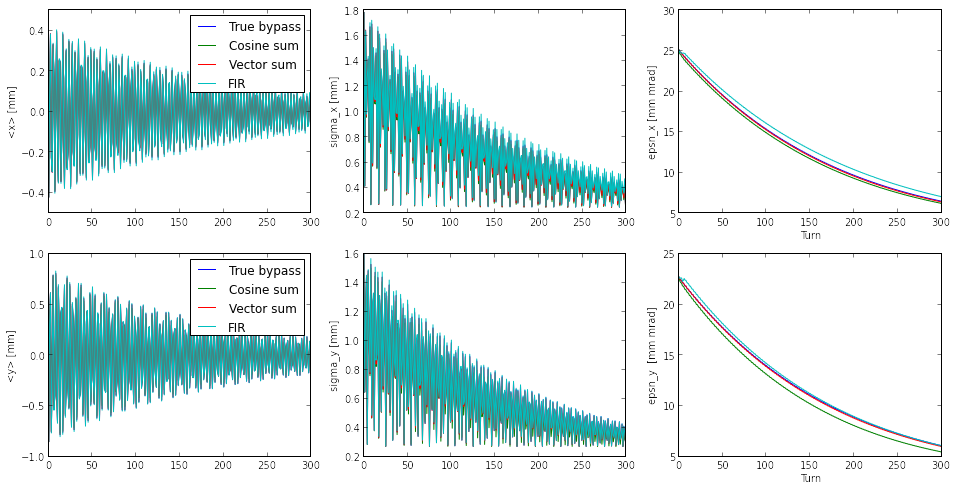

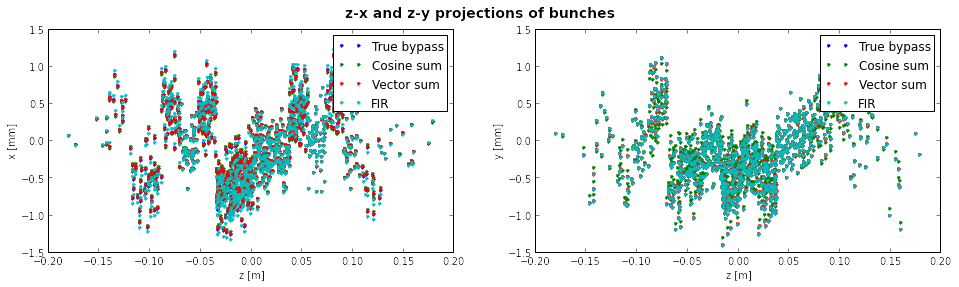

In [10]:
compare_traces([tracker_OneBox,tracker_cosine,tracker_vector,tracker_FIR],
               ['True bypass','Cosine sum','Vector sum','FIR'])
compare_projections([bunch_OneBox,bunch_cosine,bunch_vector,bunch_FIR], 
               ['True bypass','Cosine sum','Vector sum','FIR'])

In [11]:
# multiple pick-ups and kickers